In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
analysis_date = dt.date(2022, 1, 12)

In [3]:
lbt_itp_id = 170

In [317]:
importlib.reload(utils)
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [6]:
pbar = tqdm()

0it [00:00, ?it/s]

In [7]:
%%capture
lbt = rt.OperatorDayAnalysis(lbt_itp_id, analysis_date, pbar)

In [322]:
lbt.set_filter(start_time='15:00', end_time='19:00')

In [326]:
# lbt.segment_speed_map()

In [327]:
%%capture
m = rt.OperatorDayAnalysis._show_speed_map(lbt, how = 'low_speeds',
                                           colorscale = utils.ZERO_THIRTY_COLORSCALE,
                                           size = [900, 550])

In [329]:
# m

In [12]:
lbt.trips_positions_joined >> filter(_.route_id == '51') >> distinct(_.direction_id, _.shape_id, _keep_all=True)

,calitp_itp_id,service_date,trip_key,trip_id,route_id,direction_id,shape_id,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
0,170,2022-01-12,6460889386703071205,9289374,51,0,510067,1224,None,2022-01-12 08:14:18,33.876743,-118.22327,2022-01-12 08:14:55,POINT (164389.396 -458297.602)
1,170,2022-01-12,-9094923369855237176,9288369,51,1,510066,1224,None,2022-01-12 18:49:57,33.768055,-118.19030,2022-01-12 18:50:10,POINT (167669.594 -470291.215)


single shape_id for each route_id x direction_id... (by spec)

goal is to identify linked shape ids and shift by direction (to either side of centerline), plus shape segments to display progression

### Shape Manipulation

In [292]:
importlib.reload(utils)
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [293]:
one_interpolator = lbt.position_interpolators['9288385']['rt']

In [302]:
one_interpolator = lbt.position_interpolators['9288539']['rt']

In [303]:
rt.VehiclePositionsInterpolator.detailed_speed_map(one_interpolator)

/home/jovyan/data-analyses/rt_delay/rt_analysis.py:100: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [146]:
ex = one_interpolator.detailed_map_view.copy()

In [147]:
turn = ex.loc[12514]

In [148]:
geo = turn.geometry

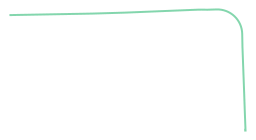

In [149]:
geo

In [151]:
geo.length

347.50276421111994

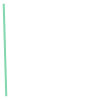

In [196]:
begin_segment = shapely.ops.substring(geo, geo.length - 50, geo.length).simplify(tolerance = 5)
begin_segment

In [197]:
arrow_distance = 15

In [198]:
r_shift = begin_segment.parallel_offset(21, 'right')
r_pt = shapely.ops.substring(r_shift, 0 , 0)
l_shift = begin_segment.parallel_offset(21, 'left')
l_pt = shapely.ops.substring(l_shift, l_shift.length, l_shift.length)

In [199]:
end = shapely.ops.substring(begin_segment,
                            begin_segment.length - arrow_distance,
                            begin_segment.length - arrow_distance)

In [200]:
poly = shapely.geometry.Polygon((r_pt, end, l_pt))

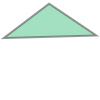

In [279]:
poly

In [202]:
result = begin_segment.buffer(20).difference(poly)

In [203]:
[x.area for x in result.geoms]

[627.3096981090166, 2154.147799987671]

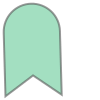

In [204]:
result.geoms[1] ## is this brittle?

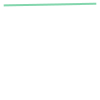

In [205]:
## ends to the left
end_segment = shapely.ops.substring(geo, 0, 50).simplify(tolerance = 5)
end_segment

In [206]:
end = shapely.ops.substring(end_segment, 0, 0) ## correct

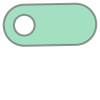

In [209]:
end_segment.buffer(20).difference(end.buffer(10))

In [219]:
r_shift = end_segment.parallel_offset(21, 'right')
r_pt = shapely.ops.substring(r_shift, r_shift.length, r_shift.length)
r_pt2 = shapely.ops.substring(r_shift, r_shift.length - arrow_distance, r_shift.length - arrow_distance)
l_shift = end_segment.parallel_offset(21, 'left')
l_pt = shapely.ops.substring(l_shift, 0, 0)
l_pt2 = shapely.ops.substring(l_shift, arrow_distance, arrow_distance)

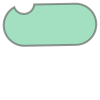

In [220]:
end_segment.buffer(20).difference(l_pt.buffer(10))

In [223]:
t1 = shapely.geometry.Polygon((l_pt2, end, l_pt))
t2 = shapely.geometry.Polygon((r_pt2, end, r_pt))

In [228]:
result = end_segment.buffer(20).difference(t1).difference(t2)

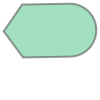

In [230]:
result.geoms[0]

In [232]:
segment_clip_mask = shapely.geometry.MultiPolygon((poly, t1, t2))

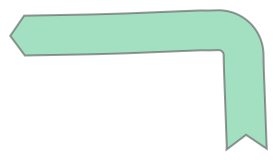

In [236]:
geo.buffer(20).difference(segment_clip_mask).geoms[0]

In [248]:
def arrowize_segment(line_geometry, arrow_distance = 15, buffer_distance = 20):
    
    segment = line_geometry.simplify(tolerance = 5)
    shift_distance = buffer_distance + 1
    
    begin_segment = shapely.ops.substring(segment, segment.length - 50, segment.length)
    r_shift = begin_segment.parallel_offset(shift_distance, 'right')
    r_pt = shapely.ops.substring(r_shift, 0 , 0)
    l_shift = begin_segment.parallel_offset(shift_distance, 'left')
    l_pt = shapely.ops.substring(l_shift, l_shift.length, l_shift.length)
    end = shapely.ops.substring(begin_segment,
                            begin_segment.length - arrow_distance,
                            begin_segment.length - arrow_distance)
    poly = shapely.geometry.Polygon((r_pt, end, l_pt)) ## triangle to cut bottom of arrow
    ## ends to the left
    end_segment = shapely.ops.substring(segment, 0, 50)
    end = shapely.ops.substring(end_segment, 0, 0) ## correct
    r_shift = end_segment.parallel_offset(shift_distance, 'right')
    r_pt = shapely.ops.substring(r_shift, r_shift.length, r_shift.length)
    r_pt2 = shapely.ops.substring(r_shift, r_shift.length - arrow_distance, r_shift.length - arrow_distance)
    l_shift = end_segment.parallel_offset(shift_distance, 'left')
    l_pt = shapely.ops.substring(l_shift, 0, 0)
    l_pt2 = shapely.ops.substring(l_shift, arrow_distance, arrow_distance)
    t1 = shapely.geometry.Polygon((l_pt2, end, l_pt)) ## triangles to cut top of arrow
    t2 = shapely.geometry.Polygon((r_pt2, end, r_pt))
    segment_clip_mask = shapely.geometry.MultiPolygon((poly, t1, t2))
    # return segment_clip_mask
    
    differences = segment.buffer(buffer_distance).difference(segment_clip_mask)
    areas = [x.area for x in differences.geoms]
    for geom in differences.geoms:
        if geom.area == max(areas):
            return geom

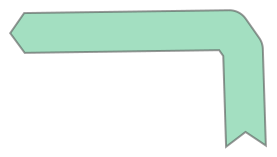

In [250]:
arrowize_segment(geo)

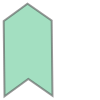

In [251]:
arrowize_segment(ex.loc[12482].geometry)

### Old

In [19]:
clip = shapely.geometry.Point(ex.geometry.centroid.x, ex.geometry.bounds[1]).buffer(25)

KeyError: 1

In [ ]:
clip

In [ ]:
top = (ex.geometry.centroid.x, ex.geometry.bounds[1] + 50)

lower_left = (ex.geometry.bounds[0] - 25, ex.geometry.bounds[1])
lower_right = (ex.geometry.bounds[2] + 25, ex.geometry.bounds[1])

In [ ]:
ex.geometry.bounds

In [ ]:
clip2 = shapely.geometry.Polygon((top, lower_left, lower_right))
clip2

In [ ]:
ex.geometry.difference(clip2)

In [ ]:
left_side = ex.geometry.bounds[0]
right_side = ex.geometry.bounds[2]
top_side = ex.geometry.bounds[3]

In [ ]:
vertex_1 = (left_side, top_side)
vertex_2 = (right_side, top_side)
vertex_3 = (right_side, top_side - 45)
vertex_4 = (ex.geometry.centroid.x, top_side - 10)
vertex_5 = (left_side, top_side - 45)

In [ ]:
clip3 = shapely.geometry.Polygon((vertex_1, vertex_2, vertex_3,
                                 vertex_4, vertex_5))
clip3

In [ ]:
ex.geometry.difference(clip2).difference(clip3)